In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import requests
import seaborn as sns
import dask.dataframe as dd


In [2]:
data_folder = '../data/'
pickle_folder = '../data/pickles/'


movies_with_wikidata_id = pickle.load(open(pickle_folder + 'movies_with_wikidata_id.p', 'rb'))
unique_movie_ids = movies_with_wikidata_id.wikidata_id.unique()
len(movies_with_wikidata_id)

81741

# Wikidata release date, box office, ratings, IMDB id

In [ ]:
from multiprocessing import Pool

wanted_features = ['P577', 'P444', 'P2142', 'P646', 'P345']

def get_wikidata_title(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        features = dict()
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        features['new_wikidata_id'] = key
        for feature in wanted_features:
            try:
                features[feature] = json_id['entities'][key]['claims'][feature][0]['mainsnak']['datavalue']['value']
            except:
                pass
        return [id, features]
    else:
        print(json_id.status_code)
        return [id, json_id.status_code]
    # return json_id['entities'][id]['labels']['en']['value']


total_len = len(unique_movie_ids)

collection = []

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata_title, unique_movie_ids), total=total_len))
# pickle.dump(collection, open(f'temp_collection_movies.p','wb'))


In [ ]:
pickle.dump(collection, open(f'temp_collection_movies.p','wb'))

In [3]:
collection = pickle.load( open(f'temp_collection_movies.p','rb'))

In [4]:
df = pd.DataFrame(collection)
failed_ids = df.loc[(df[1] == 400) | (df[1] == 404)]
pickle.dump(failed_ids, open('failed_movie_wikidata_ids.p','wb'))
df = df.drop(index=df.loc[(df[1] == 400) | (df[1] == 404)].index)
df = df.set_index(0)
df.head()

,1
0,
Q261700,"{'new_wikidata_id': 'Q261700', 'P577': {'time'..."
Q16250726,"{'new_wikidata_id': 'Q16250726', 'P577': {'tim..."
Q4978832,"{'new_wikidata_id': 'Q4978832', 'P577': {'time..."
Q7995657,"{'new_wikidata_id': 'Q7995657', 'P577': {'time..."
Q869644,"{'new_wikidata_id': 'Q869644', 'P577': {'time'..."


In [5]:
def get_feature(x, feature, fct):
    try:
        return fct(x[feature])
    except:
        return np.nan

df['new_wikidata_id'] = df[1].apply(lambda x: get_feature(x, 'new_wikidata_id', lambda y: y))
df['release_date_wd'] = pd.to_datetime(df[1].apply(lambda x: get_feature(x, 'P577', (lambda y: y['time'].removeprefix('+').removesuffix('T00:00:00Z').replace('-00-00','').replace('-00','')))),errors = 'ignore')
df['box_office_wd'] = df[1].apply(lambda x: get_feature(x, 'P2142', lambda y: int(y['amount'].removeprefix('+'))))
df['ratings_wd'] = df[1].apply(lambda x: get_feature(x, 'P444', lambda y: y))
df['freebase_id_wd'] = df[1].apply(lambda x: get_feature(x, 'P646', lambda y: y))
df['IMDB_id'] = df[1].apply(lambda x: get_feature(x, 'P345', lambda y: y))
df = df.drop(labels=[1], axis=1)
df.head()

,new_wikidata_id,release_date_wd,box_office_wd,ratings_wd,freebase_id_wd,IMDB_id
0,,,,,,
Q261700,Q261700,2001-01-01,NaN,22%,/m/03vyhn,tt0228333
Q16250726,Q16250726,2000-01-01,NaN,NaN,/m/08yl5d,tt0245916
Q4978832,Q4978832,1988-01-01,NaN,NaN,/m/0crgdbh,tt0094806
Q7995657,Q7995657,1987-01-01,NaN,50%,/m/0285_cd,tt0094320
Q869644,Q869644,1983-01-01,NaN,NaN,/m/01mrr1,tt0083949


In [6]:
movies = pd.merge(left=movies_with_wikidata_id, right=df, left_on='wikidata_id', right_index=True, how='left')
movies.keys()

Index(['Wikipedia ID', 'freebase_id', 'wikidata_id', 'name', 'release date',
       'box office revenue', 'runtime', 'languages', 'countries', 'genres',
       'new_wikidata_id', 'release_date_wd', 'box_office_wd', 'ratings_wd',
       'freebase_id_wd', 'IMDB_id'],
      dtype='object')

In [7]:
len(movies)

81741

In [87]:
pickle.dump(movies, open(pickle_folder + 'movies_with_wikidata_entries_separate.p','wb'))

In [8]:
movies =  pickle.load(open(pickle_folder + 'movies_with_wikidata_entries_separate.p','rb'))
len(movies)

81741

# IMDB ratings

In [8]:
imdb_ratings = pd.read_csv('../data/IMDB/title.ratings.tsv', sep='\t')
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1917
1,tt0000002,5.8,260
2,tt0000003,6.5,1725
3,tt0000004,5.6,173
4,tt0000005,6.2,2541


In [9]:
movies = pd.merge(left=movies, right=imdb_ratings, left_on='IMDB_id', right_on='tconst', how='left')

In [10]:
movies.drop(['tconst'],axis=1, inplace=True)

In [11]:
movies.keys()

Index(['Wikipedia ID', 'freebase_id', 'wikidata_id', 'name', 'release date',
       'box office revenue', 'runtime', 'languages', 'countries', 'genres',
       'new_wikidata_id', 'release_date_wd', 'box_office_wd', 'ratings_wd',
       'freebase_id_wd', 'IMDB_id', 'averageRating', 'numVotes'],
      dtype='object')

In [12]:
movies.loc[movies.ratings_wd.notna() & movies.averageRating.isna()]

,Wikipedia ID,freebase_id,wikidata_id,name,release date,box office revenue,runtime,languages,countries,genres,new_wikidata_id,release_date_wd,box_office_wd,ratings_wd,freebase_id_wd,IMDB_id,averageRating,numVotes
8555,3653578,/m/09sfrg,Q2303761,Return of the Fly,1959,NaN,80.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/01q03"": ""Cu...",Q2303761,1959-01-01,NaN,36%,/m/09sfrg,tt0053219,NaN,NaN
12756,25092646,/m/09gbkyq,Q4906337,Big Shots,1987-10-02,3390043.0,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action"", ""/m/01z4y"": ""Comedy""}",Q4906337,1987-01-01,NaN,60%,/m/09gbkyq,tt0092655,NaN,NaN
15230,16626966,/m/03yfwdw,Q4274071,Night of the Bloody Apes,NaN,NaN,81.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0b90_r"": ""Mexico""}","{""/m/03npn"": ""Horror"", ""/m/0hj3m_q"": ""Creature...",Q4274071,1969-02-06,NaN,0%,/m/03yfwdw,tt0063090,NaN,NaN
15720,777032,/m/03bllg,Q1041834,Suddenly,1954-10-07,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",Q1041834,1954-10-07,1400000.0,100%,/m/03bllg,tt0047542,NaN,NaN
16478,2121919,/m/06np3s,Q127430,King Kong Escapes,1967-07-22,NaN,96.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0g092b"": ""Monster movie"", ""/m/06n90"": ""Sc...",Q127430,1967-07-22,NaN,63%,/m/06np3s,tt0061868,NaN,NaN
19083,4975477,/m/0cy03w,Q3976538,Vampire Journals,1997,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",Q3976538,1993-01-01,NaN,83%,/m/0b1p2n,NaN,NaN,NaN
23871,16434354,/m/03y1rj5,Q5619254,Gunnin' For That,2008-06-27,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z02hx"": ""Sports"", ""/m/017fp"": ""Biograph...",Q5619254,2008-01-01,NaN,72%,/m/03y1rj5,NaN,NaN,NaN
26377,4196905,/m/0bpf1y,Q2225929,The Masque of the Red Death,1964,NaN,88.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",Q2225929,1964-06-24,NaN,89%,/m/0bpf1y,tt0058333,NaN,NaN
28832,3785335,/m/09_xmw,Q3976538,Subspecies 4: Bloodstorm,1998-12-08,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0qdzd"": ""B-movie"", ""/m/03npn"": ""Horror""}",Q3976538,1993-01-01,NaN,83%,/m/0b1p2n,NaN,NaN,NaN
32248,3565365,/m/09lxn7,Q2247896,The Molly Maguires,1970,2200000.0,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/04xvlr"": ""Pe...",Q2247896,1970-01-01,NaN,90%,/m/09lxn7,tt0066090,NaN,NaN


Only 27 movies that has a wikidata rating but no imdb rating: lets drop the wikidata ratings

In [13]:
movies.drop(labels='ratings_wd',axis=1, inplace=True)

In [14]:
movies.averageRating.notna().sum() / len(movies)

0.8360675793053669

# IMDB basics (release year)

In [15]:
imdb_basics = pd.read_csv('../data/IMDB/title.basics.tsv', sep='\t')
imdb_basics.head()

/tmp/ipykernel_9795/2384298691.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_basics = pd.read_csv('../data/IMDB/title.basics.tsv', sep='\t')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [16]:
(imdb_basics.startYear.isna() & imdb_basics.endYear.notna()).sum()

0

In [17]:
imdb_basics.drop(labels= ['titleType', 'isAdult', 'endYear'], axis=1, inplace=True)
imdb_basics.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0000001,Carmencita,Carmencita,1894,1,"Documentary,Short"
1,tt0000002,Le clown et ses chiens,Le clown et ses chiens,1892,5,"Animation,Short"
2,tt0000003,Pauvre Pierrot,Pauvre Pierrot,1892,4,"Animation,Comedy,Romance"
3,tt0000004,Un bon bock,Un bon bock,1892,12,"Animation,Short"
4,tt0000005,Blacksmith Scene,Blacksmith Scene,1893,1,"Comedy,Short"


In [18]:
movies = pd.merge(left=movies, right=imdb_basics, left_on='IMDB_id', right_on='tconst', how='left')
movies.keys()

Index(['Wikipedia ID', 'freebase_id', 'wikidata_id', 'name', 'release date',
       'box office revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'new_wikidata_id', 'release_date_wd', 'box_office_wd', 'freebase_id_wd',
       'IMDB_id', 'averageRating', 'numVotes', 'tconst', 'primaryTitle',
       'originalTitle', 'startYear', 'runtimeMinutes', 'genres_y'],
      dtype='object')

In [19]:
len(movies)

81741

In [20]:
def get_year(x):
    try:
        return pd.to_datetime(x, errors='ignore').year
    except:
        return np.nan

In [21]:
movies['CMU_release_year'] = movies['release date'].apply(lambda x: get_year(x))
movies['WD_release_year'] = movies['release_date_wd'].apply(lambda x: get_year(x))
movies['IMDB_release_year'] = movies['startYear'].apply(lambda x: get_year(x))

In [22]:
pickle.dump(movies, open('movies_with_ratings_and_imdb_basics.p', 'wb'))

In [22]:
movies = pickle.load(open('movies_with_ratings_and_imdb_basics.p', 'rb'))
len(movies)

81741

In [23]:
def combine_year(y1, y2, y3):
    if abs(y1 - y2) < 5:
        return y1
    elif abs(y1 - y3) < 5:
        return y1
    elif abs(y2 - y3) < 5:
        return y2
    elif y1!=np.nan:
        return y1
    elif y2!=np.nan:
        return y1
    elif y3!=np.nan:
        return y1
    else:
        return np.nan

movies['combined_release_year'] = movies.apply(lambda x: combine_year(x['CMU_release_year'], x['WD_release_year'], x['IMDB_release_year']), axis=1)

In [24]:
movies['combined_release_year'].notna().sum() / len(movies)

0.9637635947688431

# Runtime

In [25]:
def toInt(x):
    try:
        return int(x)
    except:
        return np.nan

movies['runtime'] = movies['runtime'].apply(lambda x: toInt(x))
movies['runtimeMinutes'] = movies['runtimeMinutes'].apply(lambda x: toInt(x))

In [26]:
def max_diff(df, feature1, feature2, maxdiff):
    return df.loc[(abs(df[feature1] - df[feature2]) > maxdiff) | (df[feature1].isna() & df[feature2].isna() & df['wikidata_id'].notna())]

index_to_wikidata_scrape = max_diff(movies, 'runtime', 'runtimeMinutes', 10)[['name', 'runtime', 'runtimeMinutes']].index
ids_to_scrape = movies.loc[index_to_wikidata_scrape]['wikidata_id']

len(ids_to_scrape)

10274

In [36]:
from multiprocessing import Pool

wanted_features = ['P2047']

def get_wikidata_title(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        for feature in wanted_features:
            try:
                runtime = json_id['entities'][key]['claims'][feature][0]['mainsnak']['datavalue']['value']
                if runtime['unit'] == 'http://www.wikidata.org/entity/Q7727':
                    runtime = int(runtime['amount'].replace('+', ''))
                elif runtime['unit'] == 'http://www.wikidata.org/entity/Q11574':
                    runtime = int(runtime['amount'].replace('+', ''))/60
                elif runtime['unit'] == 'http://www.wikidata.org/entity/Q25235':
                    runtime = int(runtime['amount'].replace('+', '')) * 60
                else:
                    runtime = np.nan
            except:
                runtime = np.nan
        return [id, runtime]
    else:
        print(json_id.status_code)
        return [id, np.nan]
    # return json_id['entities'][id]['labels']['en']['value']


total_len = len(ids_to_scrape)

collection = []

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata_title, ids_to_scrape), total=total_len, smoothing=1.0))
pickle.dump(collection, open(f'collection_runtimes_wd.p','wb'))


  0%|          | 0/10274 [00:00<?, ?it/s]

404
404
404
404
404
404
404
404
404


In [27]:
collection = pickle.load(open(f'collection_runtimes_wd.p','rb'))

In [28]:
runtime = pd.DataFrame(collection)
runtime = runtime.rename(columns={0: 'wikidata_id_collection', 1: 'WD_runtime'})
runtime['WD_runtime'] = runtime.WD_runtime.apply(lambda x: toInt(x))

In [29]:
movies = pd.merge(movies, runtime.drop_duplicates(), left_on='wikidata_id',  right_on='wikidata_id_collection', how='left')
movies.drop(labels=['wikidata_id_collection'], axis=1, inplace=True)

In [30]:
def get_final_runtime(x,y,z):
    if abs(x - y) < 10:
        return x
    elif abs(x - z) < 10:
        return x
    elif abs(y - z) < 10:
        return y
    elif pd.notna(x):
        return x
    elif pd.notna(y):
        return y
    elif pd.notna(z):
        return z
    else:
        return np.nan

movies['WD_runtime'] = movies.WD_runtime.apply(lambda x: toInt(x))
movies['combined_runtime'] = movies.apply(lambda x: get_final_runtime(x['runtime'], x['runtimeMinutes'], x['WD_runtime']), axis=1)


In [31]:
movies.combined_runtime.notna().sum() / len(movies)

0.8997198468332905

In [32]:
movies[['name', 'runtime', 'runtimeMinutes', 'WD_runtime', 'combined_runtime']]

,name,runtime,runtimeMinutes,WD_runtime,combined_runtime
0,Ghosts of Mars,98.0,98.0,NaN,98.0
1,Getting Away with Murder: The JonBenét Ramsey ...,95.0,95.0,NaN,95.0
2,Brun bitter,83.0,83.0,NaN,83.0
3,White Of The Eye,110.0,110.0,NaN,110.0
4,A Woman in Flames,106.0,106.0,NaN,106.0
...,...,...,...,...,...
81736,Mermaids: The Body Found,120.0,82.0,123.0,120.0
81737,Knuckle,96.0,97.0,NaN,96.0
81738,Another Nice Mess,66.0,66.0,NaN,66.0
81739,The Super Dimension Fortress Macross II: Lover...,150.0,150.0,NaN,150.0


# BoxOffice Mojo

In [6]:
from multiprocessing import Pool

wanted_features = ['P1237']

def get_wikidata_title(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        for feature in wanted_features:
            try:
                watchmojoid = json_id['entities'][key]['claims'][feature][0]['mainsnak']['datavalue']['value']
            except:
                watchmojoid = np.nan
        return [id, watchmojoid]
    else:
        print(json_id.status_code)
        return [id, json_id.status_code]
    # return json_id['entities'][id]['labels']['en']['value']


total_len = len(unique_movie_ids)

collection = []

with Pool(6) as p:
    collection =  list(tqdm(p.imap(get_wikidata_title, unique_movie_ids), total=total_len, smoothing=0))
pickle.dump(collection, open(f'temp_boxoffice_mojo_ids.p','wb'))


  0%|          | 0/77109 [00:00<?, ?it/s]

400
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404


In [11]:
mojo_id_df = pd.DataFrame(collection)
mojo_id_df = mojo_id_df.rename({0: 'wikidata_id', 1: 'mojo_id'}, axis=1)
mojo_id_df.head()

,wikidata_id,mojo_id
0,Q261700,ghostsofmars
1,Q16250726,NaN
2,Q4978832,NaN
3,Q7995657,NaN
4,Q869644,NaN


In [16]:
mojo_id_df.loc[mojo_id_df.mojo_id.isna()].index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            77099, 77100, 77101, 77102, 77103, 77104, 77105, 77106, 77107,
            77108],
           dtype='int64', length=66778)

In [20]:
mojo_id_df.drop(index=mojo_id_df.loc[mojo_id_df.mojo_id.isna()].index, inplace=True)
mojo_id_df.drop(index=mojo_id_df.loc[(mojo_id_df.mojo_id == 404 )| (mojo_id_df.mojo_id == 400)].index, inplace=True)
len(mojo_id_df)

10309

In [36]:
movies = pd.merge(movies, mojo_id_df, left_on='wikidata_id', right_on='wikidata_id', how='left')

In [37]:
movies.keys()

Index(['Wikipedia ID', 'freebase_id', 'wikidata_id', 'name', 'release date',
       'box office revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'new_wikidata_id', 'release_date_wd', 'box_office_wd', 'freebase_id_wd',
       'IMDB_id', 'averageRating', 'numVotes', 'tconst', 'primaryTitle',
       'originalTitle', 'startYear', 'runtimeMinutes', 'genres_y',
       'CMU_release_year', 'WD_release_year', 'IMDB_release_year',
       'combined_release_year', 'WD_runtime', 'combined_runtime', 'mojo_id'],
      dtype='object')

In [ ]:
movies = movies[['name', 'primaryTitle',
       'originalTitle','Wikipedia ID', 'freebase_id','freebase_id_wd', 'wikidata_id', 'new_wikidata_id',   'IMDB_id', 'mojo_id', 'release date', 'release_date_wd', 'CMU_release_year', 'WD_release_year', 'IMDB_release_year',
       'combined_release_year',  'runtime','WD_runtime', 'runtimeMinutes',  'combined_runtime',
       'box office revenue', 'box_office_wd', 'languages', 'countries',

        'averageRating', 'numVotes',   'genres_x', 'genres_y',
       ]]

movies = movies.rename({'name': 'title', 'Wikipedia ID': 'wikipedia_id', 'freebase_id': 'freebase_id_cmu',  'release date' : 'release_date_cmu', 'CMU_release_year' : 'release_year_cmu', 'WD_release_year' : 'release_year_wd',  'IMDB_release_year':'release_year_imdb',
         'runtime':'runtime_cmu', 'runtimeMinutes':'runtime_imdb', 'WD_runtime':'runtime_wd',
       'box office revenue':'box_office_cmu',
        'averageRating':'averageRating_imdb', 'numVotes':'numVotes_imdb',   'genres_x':'genres_cmu', 'genres_y':'genres_imdb'}, axis=1)
movies.head()

In [42]:
movies

,title,primaryTitle,originalTitle,wikipedia_id,freebase_id_cmu,freebase_id_wd,wikidata_id,new_wikidata_id,IMDB_id,mojo_id,...,runtime_imdb,combined_runtime,box_office_cmu,box_office_wd,languages,countries,averageRating_imdb,numVotes_imdb,genres_cmu,genres_imdb
0,Ghosts of Mars,Ghosts of Mars,Ghosts of Mars,975900,/m/03vyhn,/m/03vyhn,Q261700,Q261700,tt0228333,ghostsofmars,...,98.0,98.0,14010832.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",4.9,55061.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi"
1,Getting Away with Murder: The JonBenét Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,Getting Away with Murder: The JonBenet Ramsey ...,3196793,/m/08yl5d,/m/08yl5d,Q16250726,Q16250726,tt0245916,NaN,...,95.0,95.0,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",5.9,66.0,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",Drama
2,Brun bitter,Brun bitter,Brun bitter,28463795,/m/0crgdbh,/m/0crgdbh,Q4978832,Q4978832,tt0094806,NaN,...,83.0,83.0,NaN,NaN,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}",5.7,40.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama"
3,White Of The Eye,White of the Eye,White of the Eye,9363483,/m/0285_cd,/m/0285_cd,Q7995657,Q7995657,tt0094320,NaN,...,110.0,110.0,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",6.1,2537.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","Horror,Thriller"
4,A Woman in Flames,A Woman in Flames,Die flambierte Frau,261236,/m/01mrr1,/m/01mrr1,Q869644,Q869644,tt0083949,NaN,...,106.0,106.0,NaN,NaN,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}",6.0,587.0,"{""/m/07s9rl0"": ""Drama""}",Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,Mermaids: The Body Found,Mermaids: The Body Found,Mermaids: The Body Found,35228177,/m/0j7hxnt,/m/0j7hxnt,Q6819873,Q6819873,tt1816585,NaN,...,82.0,120.0,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",4.6,1651.0,"{""/m/07s9rl0"": ""Drama""}",Sci-Fi
81737,Knuckle,Knuckle,Knuckle,34980460,/m/0g4pl34,/m/0g4pl34,Q12125420,Q12125420,tt1606259,NaN,...,97.0,96.0,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...",6.8,3064.0,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...","Biography,Documentary,Drama"
81738,Another Nice Mess,Another Nice Mess,Another Nice Mess,9971909,/m/02pygw1,/m/02pygw1,Q4770308,Q4770308,tt0362411,NaN,...,66.0,66.0,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",5.8,101.0,"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",Comedy
81739,The Super Dimension Fortress Macross II: Lover...,Super Dimensional Fortress Macross II: Lovers ...,"Chôjikû Yôsai Macross II Lovers, Again",913762,/m/03pcrp,/m/03pcrp,Q2663931,Q2663931,tt0113726,NaN,...,150.0,150.0,NaN,NaN,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}",6.0,634.0,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...","Action,Animation,Music"


In [43]:
pickle.dump(movies, open(pickle_folder + 'movies.p', 'wb'))

percentage of title filled: 1.000%
percentage of primaryTitle filled: 0.908%
percentage of originalTitle filled: 0.908%
percentage of wikipedia_id filled: 1.000%
percentage of freebase_id_cmu filled: 1.000%
percentage of freebase_id_wd filled: 0.920%
percentage of wikidata_id filled: 0.951%
percentage of new_wikidata_id filled: 0.950%
percentage of IMDB_id filled: 0.914%
percentage of mojo_id filled: 0.127%
percentage of release_date_cmu filled: 0.916%
percentage of release_date_wd filled: 0.931%
percentage of release_year_cmu filled: 0.916%
percentage of release_year_wd filled: 0.931%
percentage of release_year_imdb filled: 0.907%
percentage of combined_release_year filled: 0.964%
percentage of runtime_cmu filled: 0.750%
percentage of runtime_wd filled: 0.027%
percentage of runtime_imdb filled: 0.841%
percentage of combined_runtime filled: 0.900%
percentage of box_office_cmu filled: 0.103%
percentage of box_office_wd filled: 0.026%
percentage of languages filled: 1.000%
percentage of 

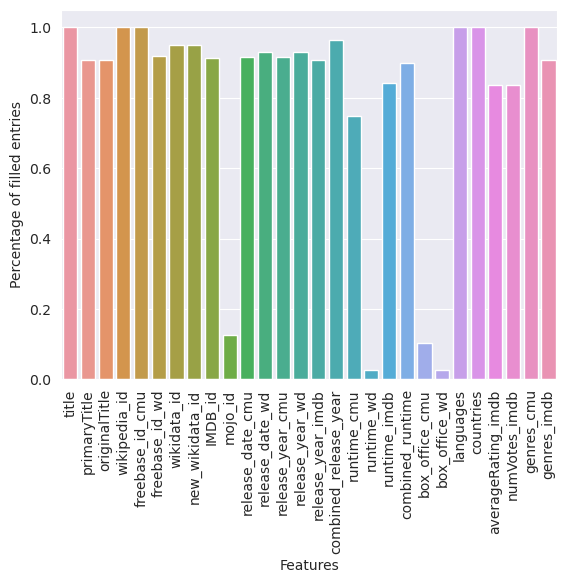

In [44]:
def get_percentage_notna(df, feature):
   return print(f'percentage of {feature} filled: {df[feature].notna().sum() / len(df):.3f}%')

features = list(movies.keys())

for feature in features:
    get_percentage_notna(movies, feature)

tempdict = {}
for feature in features:
   tempdict[feature] =  movies[feature].notna().sum() / len(movies)

tempdf = pd.DataFrame([tempdict])

ax = sns.barplot(data=tempdf)
ax.set_ylabel('Percentage of filled entries')
ax.set_xlabel('Features')
ax.tick_params('x', labelrotation=90)